In [1]:
import os
import io
import random
import numpy as np
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

import flwr as fl
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
import ray


/home/fredrik/.pyenv/versions/3.10.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-20 17:28:20,711	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 838308.06it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 281402.68it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1311324.76it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5438346.78it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



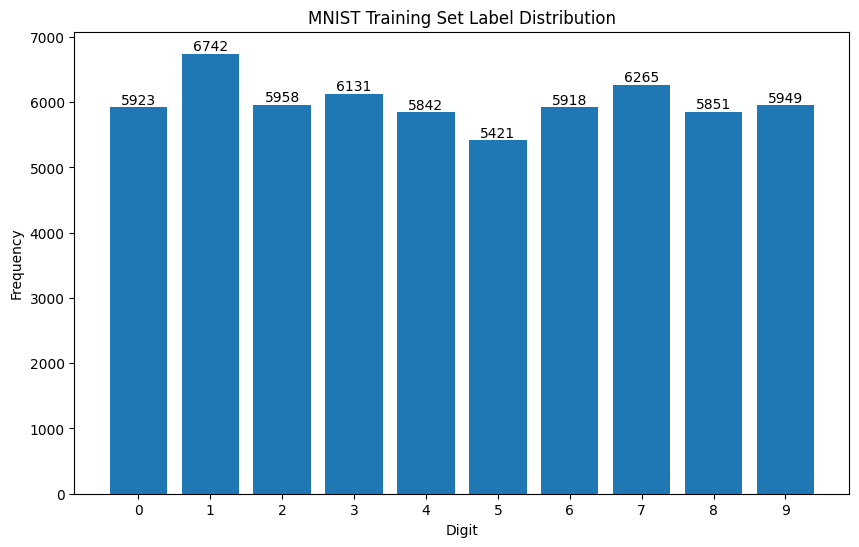

Displaying images with idx: [2391, 34210, 52137, 59390, 28746, 41861, 54795, 45839, 45388, 10414, 54818, 1066, 9302, 15042, 33394, 46245]


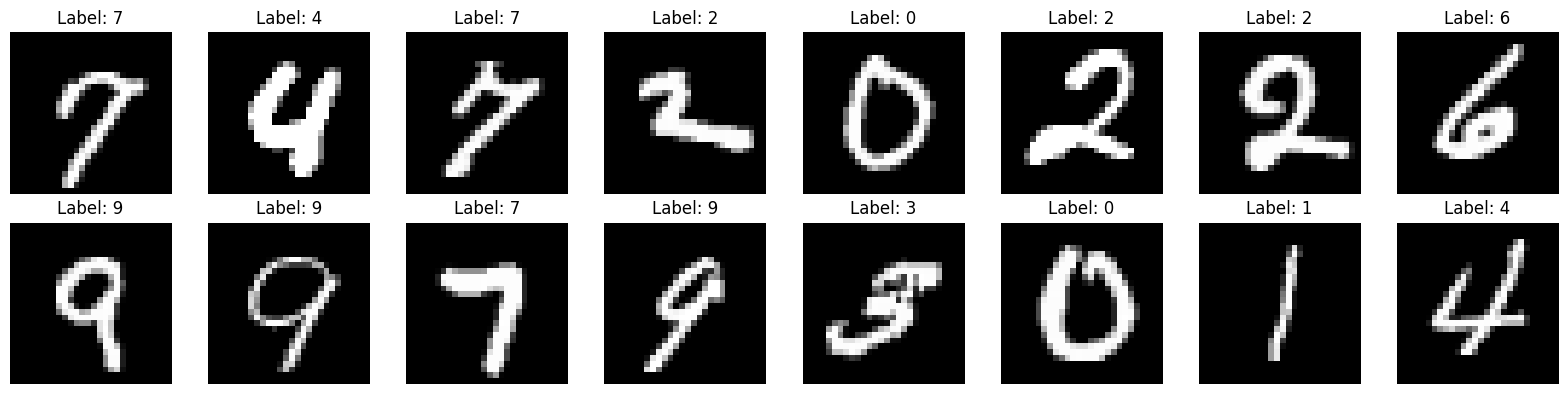

In [2]:
# Define data transformations
pytorch_transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = MNIST(root="data", train=True, download=True, transform=pytorch_transforms)
test_dataset = MNIST(root="data", train=False, download=True, transform=pytorch_transforms)

# Visualize label distribution
all_labels = train_dataset.targets.numpy()
all_label_counts = Counter(all_labels)

plt.figure(figsize=(10, 6))
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
plt.bar_label(bar)
plt.xticks(range(10))
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('MNIST Training Set Label Distribution')
plt.show()

# Function to visualize random examples
def visualize_n_random_examples(dataset, n: int, verbose: bool = True):
    if verbose:
        idx = random.sample(range(len(dataset)), n)
        print(f"Displaying images with idx: {idx}")

    num_cols = 8
    num_rows = int(np.ceil(n / num_cols))
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 2))
    axs = axs.flatten()

    for i, ax in zip(idx, axs):
        image, label = dataset[i]
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    # Hide any unused subplots
    for ax in axs[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
visualize_n_random_examples(train_dataset, n=16)


In [3]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)    # Input channels=1, Output channels=6, Kernel size=5
        self.pool = nn.MaxPool2d(2, 2)     # Kernel size=2, Stride=2
        self.conv2 = nn.Conv2d(6, 16, 5)   # Input channels=6, Output channels=16, Kernel size=5
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Fully connected layer
        self.fc2 = nn.Linear(120, 84)          # Fully connected layer
        self.fc3 = nn.Linear(84, num_classes)  # Output layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 16 * 4 * 4)            # Flatten
        x = F.relu(self.fc1(x))               # FC1 -> ReLU
        x = F.relu(self.fc2(x))               # FC2 -> ReLU
        x = self.fc3(x)                       # FC3
        return x

# Instantiate the model and count parameters
model = Net(num_classes=10)
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")


Number of parameters: 44426


In [4]:
def train(net, trainloader, optimizer, device="cpu"):
    """Train the network on the training set."""
    criterion = nn.CrossEntropyLoss()
    net.to(device)
    net.train()
    for batch in trainloader:
        images, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def test(net, testloader, device):
    """Validate the network on the test set."""
    criterion = nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

def run_centralised(trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9):
    """A minimal (but complete) centralized training loop."""
    # Instantiate the model
    model = Net(num_classes=10)

    # Discover device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Train for specified number of epochs
    for epoch in range(epochs):
        print(f"Training epoch {epoch + 1}/{epochs} ...")
        train(model, trainloader, optimizer, device)

    # Evaluate on test set
    loss, accuracy = test(model, testloader, device)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

# Prepare dataloaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Optionally run centralized training
# run_centralised(trainloader, testloader, epochs=3, lr=0.01)


In [5]:
class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()
        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=10)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def get_parameters(self):
        """Return model parameters as a list of NumPy arrays."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        """Set model parameters from a list of NumPy arrays."""
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        """Train the model on the client's training set."""
        self.set_parameters(parameters)
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        train(self.model, self.trainloader, optimizer, self.device)
        return self.get_parameters(), len(self.trainloader.dataset), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model on the client's validation set."""
        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader, self.device)
        return float(loss), len(self.valloader.dataset), {"accuracy": accuracy}


In [6]:
def set_params(model, parameters):
    """Replace model parameters with those passed as `parameters`."""
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_params(model):
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


In [7]:
def client_fn(cid: str) -> fl.client.Client:
    """Create a Flower client representing a single federated learning client."""
    # Here, we'll partition the training dataset into multiple clients
    # For simplicity, split the dataset into 100 partitions
    NUM_PARTITIONS = 100
    partition_size = len(train_dataset) // NUM_PARTITIONS
    train_subset, val_subset = random_split(train_dataset, [partition_size - int(0.1 * partition_size), int(0.1 * partition_size)])
    
    trainloader = DataLoader(train_subset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    return FlowerClient(trainloader, valloader)


In [8]:
def weighted_average(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
    """Compute weighted average of metrics."""
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    total_examples = sum(num_examples for num_examples, _ in metrics)
    return {"accuracy": sum(accuracies) / total_examples}

strategy = FedAvg(
    fraction_fit=0.1,  # 10% of clients are sampled for training each round
    fraction_evaluate=0.5,  # 50% of clients are sampled for evaluation each round
    min_fit_clients=10,
    min_evaluate_clients=10,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)


In [18]:
# Initialize Ray
ray.init(ignore_reinit_error=True)

# Define Server Configuration
server_config = ServerConfig(num_rounds=5)

# Create Server App Components
server_app_components = ServerAppComponents(strategy=strategy, config=server_config)

# Create ServerApp
server_app = ServerApp(server_app_components)

# Run the simulation
run_simulation(
    server_app=server_app,
    client_fn=client_fn,
    num_clients=100,  # Number of simulated clients
    num_workers=1,    # Number of Ray workers
    ray_init_args={"include_dashboard": False},  # Adjust as needed
    verbose=True
)


2024-11-20 17:35:02,259	INFO worker.py:1652 -- Calling ray.init() again after it has already been called.

            Check the following `FEATURE UPDATE` warning message for the preferred
            new mechanism to use this feature in Flower.
        
        ------------------------------------------------------------
        

        def server_fn(context: Context):
            server_config = ServerConfig(num_rounds=3)
            strategy = FedAvg()
            return ServerAppComponents(
                strategy=strategy,
                server_config=server_config,
        )

        app = ServerApp(server_fn=server_fn)

        ------------------------------------------------------------
        


TypeError: run_simulation() got an unexpected keyword argument 'client_fn'